# Case Study: Game Of Thrones Wordclouds

This session walks through an NLP project using scripts from Game Of Thrones to visualise word frequency in word clouds, with an added twist!

Inspired by [Inauguration speech wordclouds](https://keyonvafa.com/inauguration-wordclouds).

In [1]:
import spacy
import nltk
from nltk.corpus import stopwords
import re

import pandas as pd
import numpy as np

import unicodedata

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image
import PIL.ImageOps
from wordcloud import ImageColorGenerator
import random

In [2]:
# load language models
nlp = spacy.load("en_core_web_md")
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/kerry/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/kerry/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Get character lines

In [3]:
def get_char_lines(char):
    """ Get data for characters.
    """
    output = []
    if char == 'stark':
        starks = ['arya','sansa','ned','robb','catelyn','bran','rickon']
        for s in starks:
            output.extend(get_char_lines(s))
    elif char == 'lannister':
        lannisters = ['jaime','cersei','tyrion','tywin','myrcella','tommen','joffrey']
        for l in lannisters:
            output.extend(get_char_lines(l))
    else:
        print('Getting lines for', char)
        # data from https://github.com/shekharkoirala/Game_of_Thrones/tree/master/Data
        with open('final_data_s8.txt', 'r') as f:
            for line in f:
                if re.findall(r'(^'+char+r'.*:.*)', line, re.IGNORECASE):
                    output.append(line)
        f.close()
        print(f'{char} has {len(output)} lines')
    return output

In [4]:
# get lines for character
df = pd.DataFrame(get_char_lines('arya'), columns=['text_raw'])
df.head()

Getting lines for arya
arya has 776 lines


,text_raw
0,ARYA (pushing BRAN): Move!\n
1,ARYA: Where’s the Imp?\n
2,ARYA: Arya.\n
3,ARYA: That’s Jaime Lannister. The queen’s twin...
4,ARYA: Where’s the Imp?\n


### Clean the data

In [5]:
# replace apostrophe with single quote
df['text_clean'] = df['text_raw'].apply(lambda x : x.replace("’", "'"))
df.head(5)

,text_raw,text_clean
0,ARYA (pushing BRAN): Move!\n,ARYA (pushing BRAN): Move!\n
1,ARYA: Where’s the Imp?\n,ARYA: Where's the Imp?\n
2,ARYA: Arya.\n,ARYA: Arya.\n
3,ARYA: That’s Jaime Lannister. The queen’s twin...,ARYA: That's Jaime Lannister. The queen's twin...
4,ARYA: Where’s the Imp?\n,ARYA: Where's the Imp?\n


In [6]:
# remove brackets
df['text_clean'] = df['text_clean'].apply(lambda x: re.sub('[\(\[].*?[\)\]]', ' ', x))
df.head()

,text_raw,text_clean
0,ARYA (pushing BRAN): Move!\n,ARYA : Move!\n
1,ARYA: Where’s the Imp?\n,ARYA: Where's the Imp?\n
2,ARYA: Arya.\n,ARYA: Arya.\n
3,ARYA: That’s Jaime Lannister. The queen’s twin...,ARYA: That's Jaime Lannister. The queen's twin...
4,ARYA: Where’s the Imp?\n,ARYA: Where's the Imp?\n


In [7]:
# remove character name
df['text_clean'] = df['text_clean'].apply(lambda x: re.sub(r'.*:', '', x))
df.head()

,text_raw,text_clean
0,ARYA (pushing BRAN): Move!\n,Move!\n
1,ARYA: Where’s the Imp?\n,Where's the Imp?\n
2,ARYA: Arya.\n,Arya.\n
3,ARYA: That’s Jaime Lannister. The queen’s twin...,That's Jaime Lannister. The queen's twin brot...
4,ARYA: Where’s the Imp?\n,Where's the Imp?\n


In [8]:
# remove accented characters
df['text_clean'] = df['text_clean'].apply(lambda x: unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore'))
df.head()

,text_raw,text_clean
0,ARYA (pushing BRAN): Move!\n,Move!\n
1,ARYA: Where’s the Imp?\n,Where's the Imp?\n
2,ARYA: Arya.\n,Arya.\n
3,ARYA: That’s Jaime Lannister. The queen’s twin...,That's Jaime Lannister. The queen's twin brot...
4,ARYA: Where’s the Imp?\n,Where's the Imp?\n


In [9]:
stopword_list = stopwords.words('english')

df['text_stop_spacy'] = df['text_clean'].apply(lambda x: ' '.join([token.text.lower() for token in nlp(x) if not token.is_stop if not token.is_punct]))
df['text_stop_nltk'] = df['text_clean'].apply(lambda x: ' '.join([token.lower() for token in nltk.word_tokenize(x) if token not in stopword_list if token.isalpha()]))
df['text_lemma_stop'] = df['text_clean'].apply(lambda x: ' '.join([token.lemma_.lower() for token in nlp(x) if not token.is_stop if not token.is_punct]))
df['text_lemma_only'] = df['text_clean'].apply(lambda x: ' '.join([token.lemma_.lower() for token in nlp(x) if not token.is_punct]))
df.head()

,text_raw,text_clean,text_stop_spacy,text_stop_nltk,text_lemma_stop,text_lemma_only
0,ARYA (pushing BRAN): Move!\n,Move!\n,\n,move,\n,move \n
1,ARYA: Where’s the Imp?\n,Where's the Imp?\n,imp \n,where imp,imp \n,where be the imp \n
2,ARYA: Arya.\n,Arya.\n,arya \n,arya,arya \n,arya \n
3,ARYA: That’s Jaime Lannister. The queen’s twin...,That's Jaime Lannister. The queen's twin brot...,jaime lannister queen twin brother \n,that jaime lannister the queen twin brother,jaime lannister queen twin brother \n,that be jaime lannister the queen 's twin br...
4,ARYA: Where’s the Imp?\n,Where's the Imp?\n,imp \n,where imp,imp \n,where be the imp \n


In [12]:
df['text_stop_final'] = df['text_lemma_only'].apply(lambda x: ' '.join([token.lower() for token in nltk.word_tokenize(x) if token not in stopword_list if token.isalpha()]))
df.head()

,text_raw,text_clean,text_stop_spacy,text_stop_nltk,text_lemma_stop,text_lemma_only,text_stop_final
0,ARYA (pushing BRAN): Move!\n,Move!\n,\n,move,\n,move \n,move
1,ARYA: Where’s the Imp?\n,Where's the Imp?\n,imp \n,where imp,imp \n,where be the imp \n,imp
2,ARYA: Arya.\n,Arya.\n,arya \n,arya,arya \n,arya \n,arya
3,ARYA: That’s Jaime Lannister. The queen’s twin...,That's Jaime Lannister. The queen's twin brot...,jaime lannister queen twin brother \n,that jaime lannister the queen twin brother,jaime lannister queen twin brother \n,that be jaime lannister the queen 's twin br...,jaime lannister queen twin brother
4,ARYA: Where’s the Imp?\n,Where's the Imp?\n,imp \n,where imp,imp \n,where be the imp \n,imp


### Cleaning Functions

In [13]:
def remove_apostrophe(text):
    return text.replace("’", "'")

def remove_char(text):
    return re.sub(r'.*:', '', text)

def remove_brackets(text):
    return re.sub('[\(\[].*?[\)\]]', ' ', text)

def remove_accented_chars(text):
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

def remove_special_chars(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
    return re.sub(pattern, '', text)

def remove_stopwords_nltk(text):
    stopword_list = stopwords.words('english')
    return ' '.join([token.lower() for token in nltk.word_tokenize(text) if token not in stopword_list if token.isalpha()])

def remove_stop_spacy(text):
    return  ' '.join([token.text.lower() for token in nlp(text) if not token.is_stop if not token.is_punct])

def lemma_stop(text):
    return  ' '.join([token.lemma_.lower() for token in nlp(text) if not token.is_stop if not token.is_punct])

def lemmatize(text):
    return ' '.join([token.lemma_.lower() for token in nlp(text) if not token.is_punct])

In [14]:
df['text_clean_final'] = df['text_raw'].apply(remove_apostrophe).apply(remove_char).apply(remove_brackets).apply(remove_accented_chars).apply(lemmatize).apply(remove_stopwords_nltk)
print(f'''Number of words for Arya: {df['text_clean_final'].apply(lambda x: len(x.split(' '))).sum()}''')
df.head()

Number of words for Arya: 2737


,text_raw,text_clean,text_stop_spacy,text_stop_nltk,text_lemma_stop,text_lemma_only,text_stop_final,text_clean_final
0,ARYA (pushing BRAN): Move!\n,Move!\n,\n,move,\n,move \n,move,move
1,ARYA: Where’s the Imp?\n,Where's the Imp?\n,imp \n,where imp,imp \n,where be the imp \n,imp,imp
2,ARYA: Arya.\n,Arya.\n,arya \n,arya,arya \n,arya \n,arya,arya
3,ARYA: That’s Jaime Lannister. The queen’s twin...,That's Jaime Lannister. The queen's twin brot...,jaime lannister queen twin brother \n,that jaime lannister the queen twin brother,jaime lannister queen twin brother \n,that be jaime lannister the queen 's twin br...,jaime lannister queen twin brother,jaime lannister queen twin brother
4,ARYA: Where’s the Imp?\n,Where's the Imp?\n,imp \n,where imp,imp \n,where be the imp \n,imp,imp


### Generate WordCloud

In [15]:
# rejoin words
' '.join(df['text_clean_final'][:10])

'move imp arya jaime lannister queen twin brother imp thank nymeria septa mordane say thing properly fold say care fold go get mess anyway watch nymeria glove shut nymeria glove present skinny'

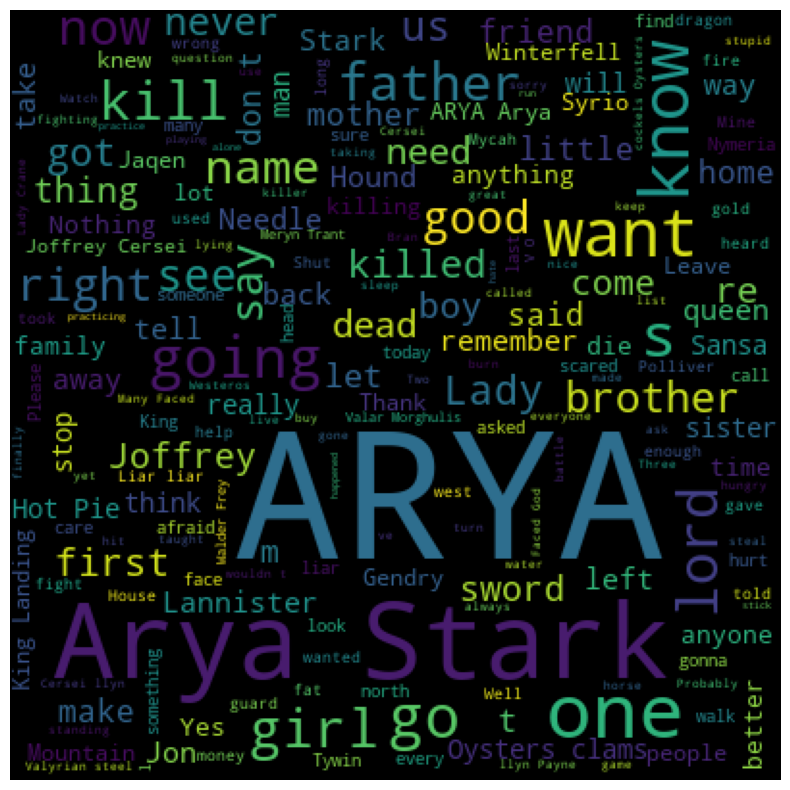

In [16]:
wc = WordCloud(background_color="black", max_words=200, width=400, height=400).generate(' '.join(df['text_raw']))

def make_plot(wc, col_fn=None):
    plt.figure(figsize=(20,10))
    plt.axis('off')
    plt.style.use('dark_background')
    plt.imshow(wc.recolor(color_func=col_fn))
make_plot(wc)

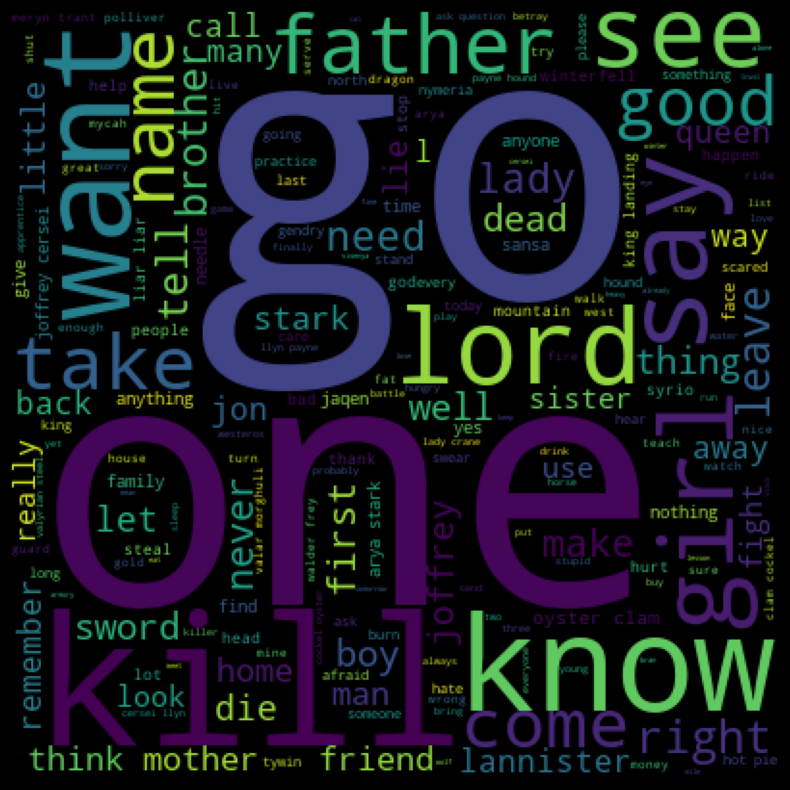

In [17]:
wc = WordCloud(background_color="black", max_words=200, width=400, height=400).generate(' '.join(df['text_clean_final']))

make_plot(wc)

Note: `generate()` function also runs some text processing and further removes stop words. It processes unigrams and bi-grams.

In [18]:
freq = {}

for word in ' '.join(df['text_clean_final']).split():
    freq[word] = freq.get(word, 0) + 1

pd.DataFrame.from_dict(freq, orient='index', columns=['count']).sort_values(by='count', ascending=False)

,count
go,62
one,51
kill,47
know,44
would,41
...,...
lt,1
chicken,1
pride,1
gift,1


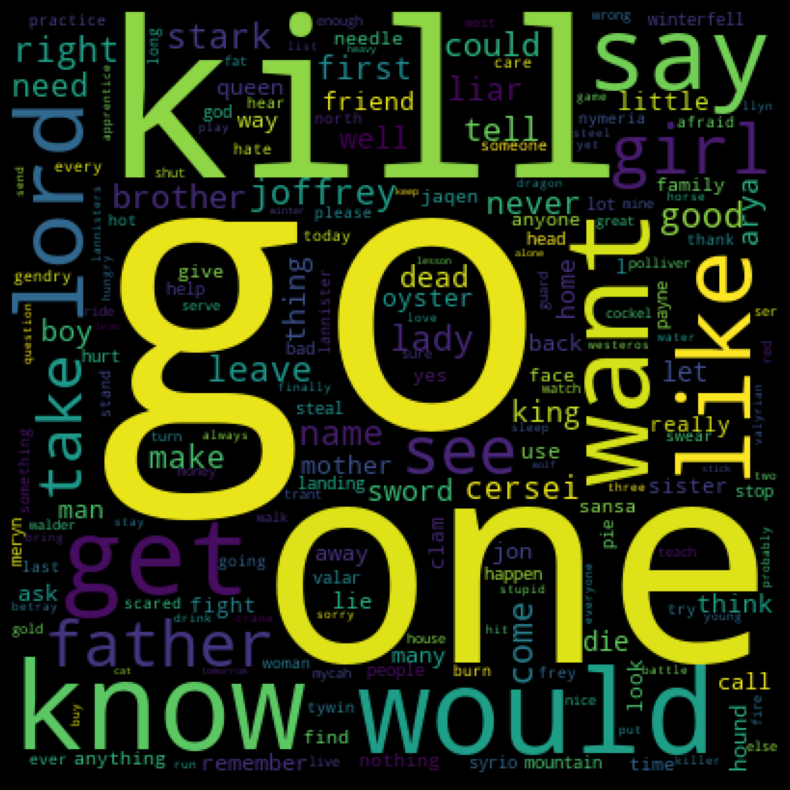

In [19]:
wc = WordCloud(background_color="black", max_words=200, width=400, height=400).generate_from_frequencies(freq)

make_plot(wc)

### Using a mask

In [20]:
def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    # from https://github.com/amueller/word_cloud/blob/master/examples/a_new_hope.py
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

char_mask = np.array(Image.open("02b_input/arya_mask_white_bkg.jpeg"))

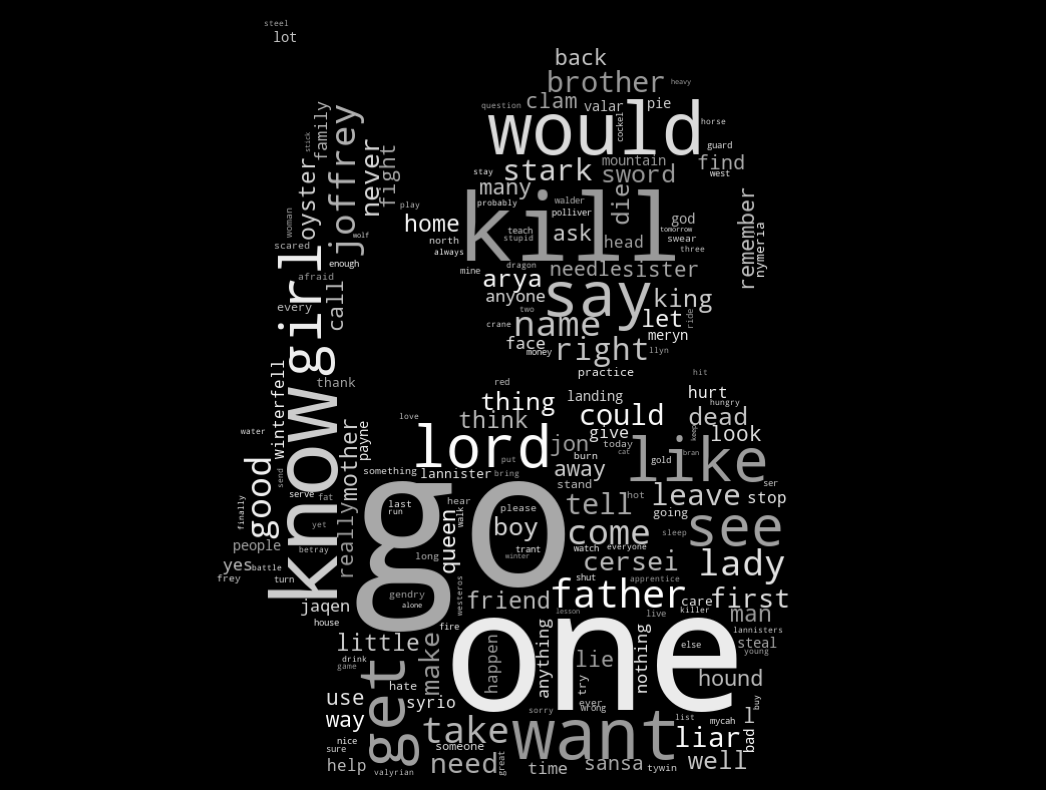

In [21]:
wc = WordCloud(background_color="black", max_words=200, width=400, height=400, #contour_width=3, contour_color='white',
mask=char_mask, random_state=1).generate_from_frequencies(freq)

make_plot(wc, grey_color_func)


## Putting it all together

In [34]:
def run_wordcloud(character, mask=False, data_only=False):
    df = pd.DataFrame(get_char_lines(character), columns=['text_raw'])
    df['text_clean_final'] = df['text_raw'].apply(remove_apostrophe).apply(remove_char).apply(remove_brackets).apply(remove_accented_chars).apply(lemmatize).apply(remove_stopwords_nltk)

    print(f'''Number of words for {character}: {df['text_clean_final'].apply(lambda x: len(x.split(' '))).sum()}''')

    if data_only:
        return df

    freq = {}

    for word in ' '.join(df['text_clean_final']).split():
        freq[word] = freq.get(word, 0) + 1

    # import image
    if mask:
        char_mask = np.array(Image.open(f'images/{character}_mask_white_bkg.jpeg'))
        image_colors = ImageColorGenerator(char_mask)
        wc = WordCloud(background_color="black", max_words=200, width=400, height=400, mask=char_mask, random_state=1).generate_from_frequencies(freq)

    else:
        wc = WordCloud(background_color="black", max_words=200, width=400, height=400, random_state=1).generate_from_frequencies(freq)
        # wc = WordCloud(background_color="black", max_words=200, width=400, height=400, random_state=1).generate(' '.join(df['text_clean_final']))

    make_plot(wc, grey_color_func) # can also use image_colors to recreate using the same colours as image
    # plt.savefig(f'output/wordcloud_{character}_black_bkg.png', dpi=200)

Getting lines for daenerys
daenerys has 988 lines
Number of words for daenerys: 4928


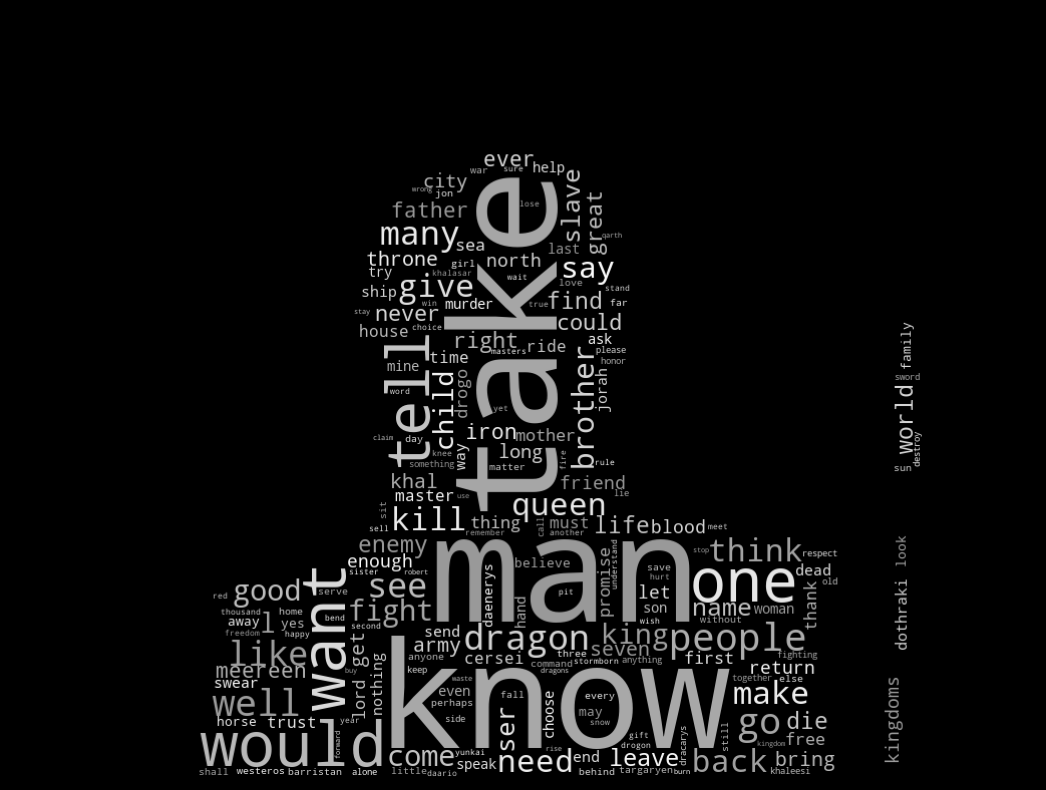

In [35]:
run_wordcloud('daenerys', True)

Getting lines for jon
jon has 1138 lines
Number of words for jon: 5250


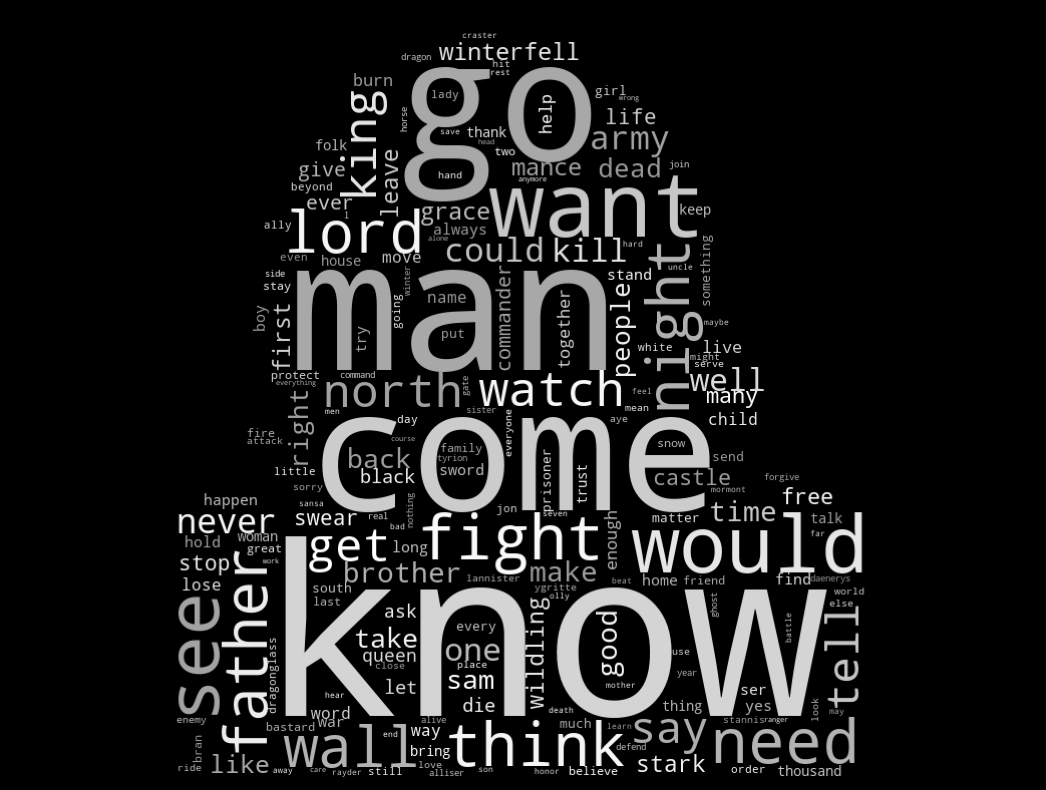

In [36]:
run_wordcloud('jon', True)

Getting lines for arya
arya has 776 lines
Getting lines for sansa
sansa has 800 lines
Getting lines for ned
ned has 114 lines
Getting lines for robb
robb has 333 lines
Getting lines for catelyn
catelyn has 302 lines
Getting lines for bran
bran has 399 lines
Getting lines for rickon
rickon has 23 lines
Number of words for stark: 11265


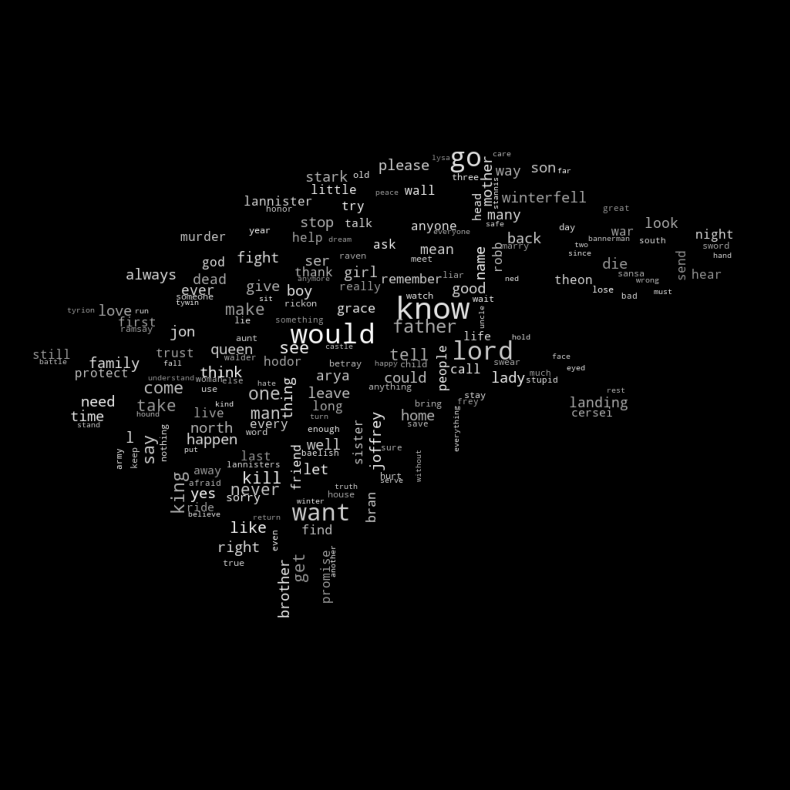

In [37]:
run_wordcloud('stark', True)

Getting lines for jaime
jaime has 932 lines
Getting lines for cersei
cersei has 1010 lines
Getting lines for tyrion
tyrion has 1752 lines
Getting lines for tywin
tywin has 386 lines
Getting lines for myrcella
myrcella has 33 lines
Getting lines for tommen
tommen has 119 lines
Getting lines for joffrey
joffrey has 266 lines
Number of words for lannister: 27579


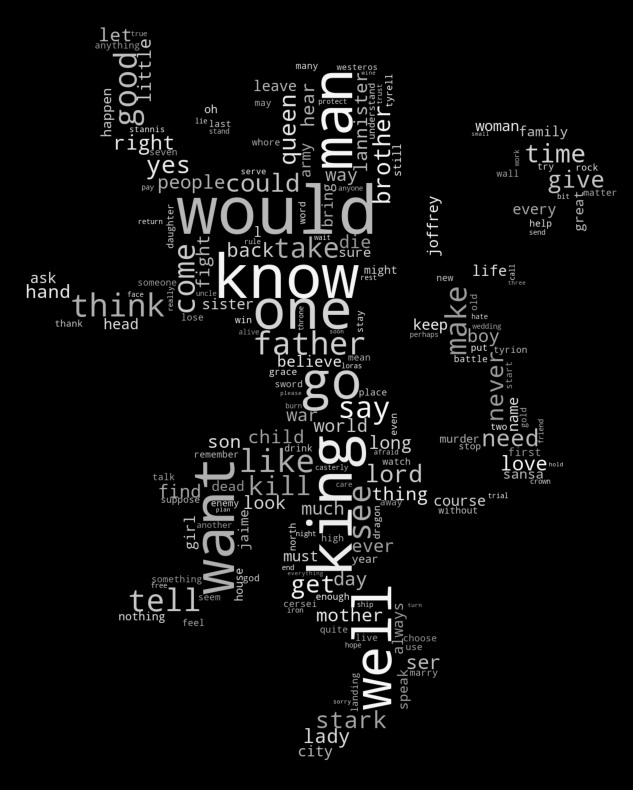

In [38]:
run_wordcloud('lannister', True)

Getting lines for 
 has 24845 lines
Number of words for : 131203


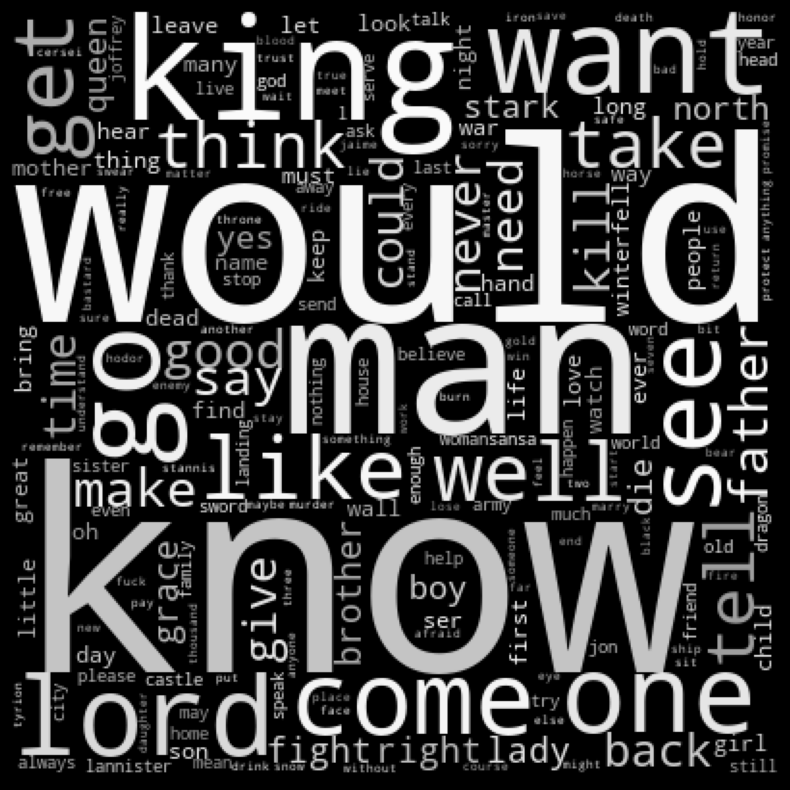

In [39]:
# all characters
run_wordcloud('')